In [120]:
import warnings
warnings.filterwarnings("ignore")

### Load Packages

In [121]:
import pandas as pd
import numpy as np
import chardet
import re
import openpyxl
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from pattern.text.en import spelling
from pattern.text.en import suggest
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob
import gensim
import pyLDAvis.gensim_models
import statistics as st
from scipy.stats import stats,mode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Reading Data

In [122]:
file="Diet_Data_Apr2020.csv"
df=pd.DataFrame()

def f_Read_Data(data):
    if ".csv" in data:
        import chardet
        with open(f'{data}', 'rb') as f:
            result = chardet.detect(f.readline())
        try:
            df=pd.read_csv(f'{data}', sep="\t",encoding = 'utf-8-sig')
        except:
            df=pd.read_csv(f'{data}', sep="\t", encoding = 'utf-8')
    return df

In [123]:
data= f_Read_Data(file)

## Edit Headers

In [124]:
data.reset_index(0)
data.rename(columns={'0': 'text',
                        '1': 'id',
                        '2': 'created_at',
                        '3': 'place',
                        '4': 'truncated',
                        '5': 'is_quote_status',
                        '6': 'retweeted',
                        '7': 'favorite_count',
                        '8': 'retweet_count',
                        '9': 'geo',
                        '10': 'lang',
                        '11': 'hashtags',
                        '12': 'retweeted_status_id',
                        '13': 'retweeted_status_user_id',
                        '14': 'retweeted_status_user_screen_name',
                        '15': 'retweeted_extended_tweet',
                        '16': 'user_id', #id same as 1nd column but this user id
                        '17': 'name',
                        '18': 'screen_name',
                        '19': 'followers_count',
                        '20': 'friends_count',
                        '21': 'favourites_count',
                        '22': 'listed_count',
                        '23': 'statuses_count',
                        '24': 'description',
                        '25': 'location',
                        '26': 'user_created_at', #created_at same as 2nd column but this user created_at
                        '27': 'utc_offset',
                        },inplace=True)


### Add Hashtag Count Column

In [125]:
data['hashtags']=data['hashtags'].apply(lambda x: str(x).replace("nan","bos"))
data['hashtag_count']=data['hashtags'].apply(lambda x: len(str(x).split(' ')) if(str(x)!="bos") else 0)
data.sample(1)

,text,id,created_at,place,truncated,is_quote_status,retweeted,favorite_count,retweet_count,geo,lang,hashtags,retweeted_status_id,retweeted_status_user_id,retweeted_status_user_screen_name,retweeted_extended_tweet,user_id,name,screen_name,followers_count,friends_count,favourites_count,listed_count,statuses_count,description,location,user_created_at,hashtag_count
64242,8 Healthy Diet Tweaks The desire to get health...,1247503176724549634,Tue Apr 07 12:35:09 +0000 2020,None,False,False,False,0.0,0.0,None,en,bos,1.247502e+18,9.482858e+17,AHealthyBod,8 Healthy Diet Tweaks The desire to get health...,1.174082e+18,Writer Kaylene,WriterKaylene,1587.0,1503.0,686.0,11.0,1674.0,Helping you achieve your business goals with p...,DFW,Tue Sep 17 22:05:36 +0000 2019\n,0


#### ID values float64. Data was corrupted by scientific numbers. Convert string...

In [126]:
cols = ['retweeted_status_user_id',"user_id","retweeted_status_id"]
for i in data[cols]:
    try:
        data[i] = data[i].apply(lambda x:"{:f}".format(float(x)))
        data[i] = data[i].apply(lambda x: str(x)[0:(str(x).find('.'))])
    except:pass

#### User created at values endswith ***"\n"*** char. cleaning...


In [127]:
try:
    data['user_created_at'] = data['user_created_at'].apply(lambda x: str(x).replace("\n",""))
except:pass

## Duplicates Drops

In [128]:

print(data.shape[0])
Del_Rows = data[(data["id"].isnull()==True) | (data["user_id"]=="na")].index
data.drop(Del_Rows,axis=0,inplace=True)
# data.drop_duplicates(['user_id','text'],inplace=True) # if u want by user+text
data.drop_duplicates(['text'],inplace=True)
print(data.shape[0])


300555
174272


## Data Summary

In [129]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['MISSING VAL', 'RATIO'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail = 5):
    print(" DATA SHAPE ".center(82,'~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print(" DATA TYPES ".center(82,'~'))
    print(df.dtypes.T)
    print("".center(82,'~'))
    print(missing_values_analysis(df))
    print(" DESCRIBE ".center(82,'~'))
    print(data.describe().T)
    print("".center(82,'~'))
    print(' DUPLICATED VALUES '.center(83,'~'))
    print(df.duplicated().sum())
    print(" QUANTILES ".center(82,'~'))
    print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

print(check_dataframe(data))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ DATA SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 174272
Columns: 28
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ DATA TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
text                                  object
id                                    object
created_at                            object
place                                 object
truncated                             object
is_quote_status                       object
retweeted                             object
favorite_count                       float64
retweet_count                        float64
geo                                   object
lang                                  object
hashtags                              object
retweeted_status_id                   object
retweeted_status_user_id              object
retweeted_status_user_screen_name     object
retweeted_extended_tweet              object
user_id                               object
name                                  object

In [130]:
def check_class(x):
    nun_df = pd.DataFrame({'Vars': x.columns,'Class': [x[i].nunique() for i in x.columns]})
    nun_df = nun_df.sort_values('Class', ascending=False)
    nun_df = nun_df.reset_index(drop=True)
    return nun_df
check_class(data)

,Vars,Class
0,text,174272
1,id,174272
2,created_at,166576
3,screen_name,133200
4,user_id,132999
5,user_created_at,132804
6,name,122783
7,description,118397
8,statuses_count,58111
9,favourites_count,48354


### Cleaning text and add column ['clean_text']

In [131]:
'''
# IF U TRY LAMBDA THIS OR DOWN FUNCTION 
# data['clean_text'] = data['text'].apply(lambda x: str(x).lower().replace(": //","://")) #https :// cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'(http|https)?://[A-Za-z0-9./]+', '', x , flags=re.MULTILINE)) # all url cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", x)) #mail adress cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: str(x).replace(".com"," ")) #.com cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'@[A-Za-z0-9]+', "", x)) # mention cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'#[A-Za-z0-9]+', "", x)) # hashtag cleaning - already have hashtag column. if we optional not delete.
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'[^A-Za-z]+', " ", x)) # alphanumeric char cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'^\s+', "", x))
'''

my_stopwords=stopwords.words("english")
#sorted part part cleaning.. if u want more short codes.
def f_clean_texts(x):
    x=x.lower()
    x=x.replace(": //","://")
    x=re.sub(r'(http|https)?://[A-Za-z0-9./]+', '', x , flags=re.MULTILINE) # all url cleaning
    x=re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", x) #mail adress cleaning
    x=str(x).replace(".com"," ") #.com cleaning
    x=re.sub(r'@[A-Za-z0-9]+', "", x) # mention cleaning
    x= re.sub(r'#[A-Za-z0-9]+', "", x) # hashtag cleaning - already have hashtag column. if we optional not delete.
    x= re.sub(r'[^A-Za-z]+', " ", x) # alphanumeric char cleaning
    x= re.sub(r'^\s+', "", x)
    x=" ".join([i for i in x.split() if i not in my_stopwords])
    x=" ".join([i for i in x.split() if len(i)>1])
    return x
data['clean_text']=data['text'].apply(lambda x: f_clean_texts(str(x)))
data['description']=data['description'].apply(lambda x: f_clean_texts(str(x)))
data['name']=data['name'].apply(lambda x: f_clean_texts(str(x)))
data['clean_text'].sample(3)

273839          need vitamin
271948    worst word fasting
190801     healthy diet plan
Name: clean_text, dtype: object

> after drop stopwords, use filter min 100 character

In [132]:
data=data[(data['text'].str.len()>=100)] 
print(f"Last Data Row Count: {data.shape[0]}")

Last Data Row Count: 120058


# TOKENIZE

In [133]:
# english language grammer rules - same char repeat max 2.
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

# Word Stemming
ps = PorterStemmer() # if u want use Lancaster. Lancaster more than agressive stemmer.
def f_stemmer(x):
    words=[]
    for i in x:
        stem_word=ps.stem(i)
        words.append(stem_word)
    return words

# Lemmatizer and similarity. türkçe'de kök değil ancak mastar ekleri vb. çıkması gibi düşünebiliriz. 
lemma = WordNetLemmatizer()
def f_lemmatizer(x):
    words=[]
    for i in x:
        i=reduce_lengthening(i)
        sug=suggest(i)
        lemma_word=lemma.lemmatize(sug[0][0])
        words.append(lemma_word)
    return words
'''
# lemmatizer and similar words edited function but many times so not use now. for sentences
'''
def f_lemmatizer_and_join(x): 
    words=str(x).split()
    new_words=[]
    for i in words:
        i=reduce_lengthening(i)
        sug=suggest(i)
        lemma_word=lemma.lemmatize(sug[0][0])
        new_words.append(lemma_word)
    sentence=' '.join(new_words)
    return sentence
'''
# similar words edited function. for sentences
'''
def f_similar_word_change(x): 
    new_words=[]
    for i in x:
        i=reduce_lengthening(i)
        sug=suggest(i)
        new_words.append(sug[0][0])
    sentence=' '.join(new_words)
    return sentence

In [134]:
'''
# IF U WANT TEST
'''
# df_asd['c1']=data['clean_text'][:5]
# print(df_asd['c1'])
# df_asd['c2']=df_asd['c1'].apply(lambda x: f_lemmatizer_and_join(x))
# print(df_asd['c2'])

'\n# IF U WANT TEST\n'

In [135]:
# merge keto & ketogen for topics ngram
data['clean_text']=data['clean_text'].apply(lambda x: str(x).replace(" keto "," ketogen ")) 

### STEMMING WORDS

In [136]:
'''
# IF U WANT LEMMA + SIMILAR WORDS CHANGES
# data['clean_text_lemma']=data['clean_text'].apply(lambda x: f_lemmatizer_and_join(x)) #normalize + similar
# data['text_tokenize']=data['text_tokenize'].apply(lambda x: f_lemmatizer(x)) #normalize words
'''
data['text_tokenize_stem']=data['clean_text'].apply(lambda x: f_stemmer(str(x).split()))
data.sample(1)

,text,id,created_at,place,truncated,is_quote_status,retweeted,favorite_count,retweet_count,geo,lang,hashtags,retweeted_status_id,retweeted_status_user_id,retweeted_status_user_screen_name,retweeted_extended_tweet,user_id,name,screen_name,followers_count,friends_count,favourites_count,listed_count,statuses_count,description,location,user_created_at,hashtag_count,clean_text,text_tokenize_stem
82780,@MrsGoodoz @martuk56 @patriot_paula @David_Mag...,1248049461110210565,Thu Apr 09 00:45:53 +0000 2020,None,True,False,False,0.0,0.0,None,en,bos,na,na,NaN,NaN,1005221302792327168,dog,DogsBCool,12929.0,12201.0,49428.0,9.0,40723.0,trying save progs make america great rts neces...,None,Fri Jun 08 22:53:29 +0000 2018,0,paula magausa waste liberal bruette always hun...,"[paula, magausa, wast, liber, bruett, alway, h..."


### NGRAMS CREATE

In [137]:
from nltk.util import ngrams
def get_ngrams(x,n=2):
    n_grams = ngrams(x, n)
    return [ ' '.join(grams) for grams in n_grams]

data['text_tokenize_ngram']=data['text_tokenize_stem'].apply(lambda x: get_ngrams(x))
data['text_tokenize_ngram'].sample(3)

29546     [quarantin updat, updat develop, develop alcoh...
92263     [food today, today mostli, mostli cracker, cra...
258518    [twitter thread, thread peopl, peopl physic, p...
Name: text_tokenize_ngram, dtype: object

# **WORDCLOUD**

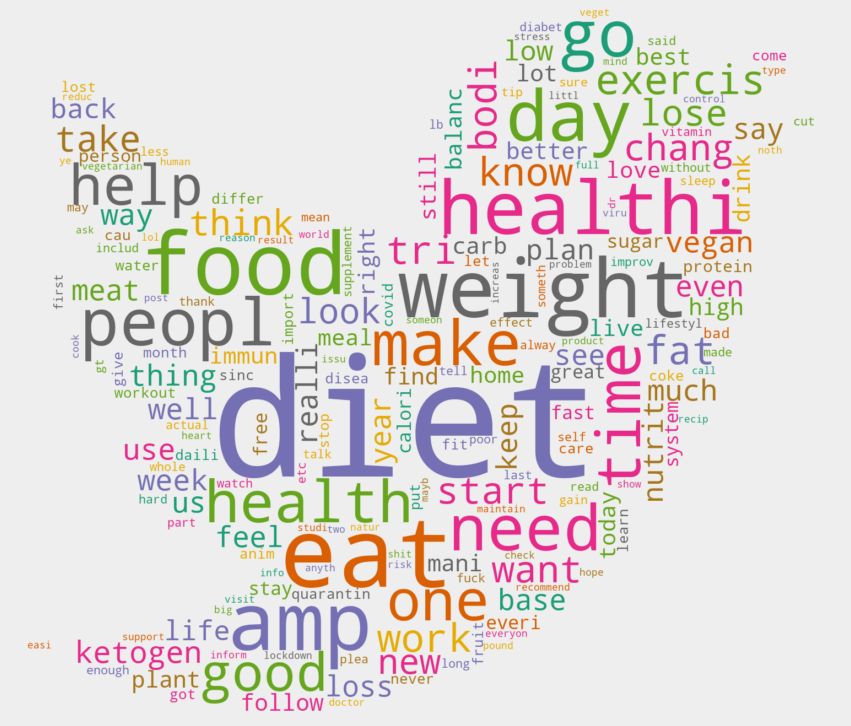

<Figure size 432x288 with 0 Axes>

In [138]:
cloud_text=[]

for i,j in data['text_tokenize_stem'].iteritems():
    for a in j:
        cloud_text.append(a+' ')
df_word_cloud=pd.DataFrame({'Head': cloud_text})
ctext =' '.join(i for i in df_word_cloud['Head'])
mask_img = np.array(Image.open("twitter.png"))
word_cloud = WordCloud(collocations=False,background_color="#eeeeee",width=1200,height=1200,mask=mask_img,mode="CMYK",colormap='Dark2').generate(ctext)
plt.figure(figsize=(15,15),facecolor="#eeeeee")
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('WordCloud_Diet.png', bbox_inches='tight')

### TEXTBLOB SENTIMENT ANALYZE

In [139]:
# '''
# # Sentiment analysis
# '''

# df=pd.DataFrame()
# df['text']=data['clean_text'][0:20]

# df[['polarity','subjectivity']] = df['text'].apply(lambda x: pd.Series(TextBlob(str(x)).sentiment))
# for row, value in df['text'].iteritems():
#     score = SentimentIntensityAnalyzer().polarity_scores(value)
#     neg = score['neg']
#     neu = score['neu']
#     pos = score['pos']
#     com=score['compound']
#     if neg > pos :
#         df.loc[row, 'sentiment'] = "Negative"
#     elif pos > neg:
#         df.loc[row, 'sentiment'] = "Positive"
#     else:
#         df.loc[row, 'sentiment'] = "Neutral"
        
# df
# df.sentiment.value_counts().plot(kind='bar',title="sentiment analysis") 

### NLTK VADER SENTIMENT ANALYZE

,text,id,created_at,place,truncated,is_quote_status,retweeted,favorite_count,retweet_count,geo,lang,hashtags,retweeted_status_id,retweeted_status_user_id,retweeted_status_user_screen_name,retweeted_extended_tweet,user_id,name,screen_name,followers_count,friends_count,favourites_count,listed_count,statuses_count,description,location,user_created_at,hashtag_count,clean_text,text_tokenize_stem,text_tokenize_ngram,senti_scores,compound,sentiment_type
126998,"@chrystarjung you're welcome unnie, i hope you...",1249695441140060161,Mon Apr 13 13:46:26 +0000 2020,None,True,False,False,0.0,0.0,None,en,bos,na,na,NaN,NaN,980083901866455040,,baeikyerin,117.0,40.0,58.0,1.0,408.0,flower prettier others unique way,fake,Sat Mar 31 14:06:26 +0000 2018,0,welcome unnie hope stay safe staying home sinc...,"[welcom, unni, hope, stay, safe, stay, home, s...","[welcom unni, unni hope, hope stay, stay safe,...","{'neg': 0.068, 'neu': 0.552, 'pos': 0.38, 'com...",0.8625,Positive
37874,@MariaEmmerich @gracexyeo @PClark14 @paigeneb ...,1246531850492940290,Sat Apr 04 20:15:27 +0000 2020,None,True,False,False,0.0,0.0,None,en,bos,na,na,NaN,NaN,2975949616,maga sub,SubThoughtz,2167.0,517.0,32063.0,62.0,70493.0,new account old one got hacked mill link baske...,None,Tue Jan 13 05:50:30 +0000 2015,0,vault referring diet one group people european...,"[vault, refer, diet, one, group, peopl, europe...","[vault refer, refer diet, diet one, one group,...","{'neg': 0.178, 'neu': 0.734, 'pos': 0.087, 'co...",-0.3818,Negative
160310,I hope we’ll start talking about how diet impa...,1250741822923649025,Thu Apr 16 11:04:22 +0000 2020,None,False,False,False,0.0,0.0,None,en,bos,1249850897720651776,1421617945,OxVerte,I hope we’ll start talking about how diet impa...,18274915,selina ang,SelinaAng,890.0,1992.0,459.0,60.0,4536.0,gastronomy fanatic tree hugger traveler sponge...,"New York, NY",Sat Dec 20 23:29:58 +0000 2008,0,hope start talking diet impacts society abilit...,"[hope, start, talk, diet, impact, societi, abi...","[hope start, start talk, talk diet, diet impac...","{'neg': 0.076, 'neu': 0.759, 'pos': 0.165, 'co...",0.4215,Positive


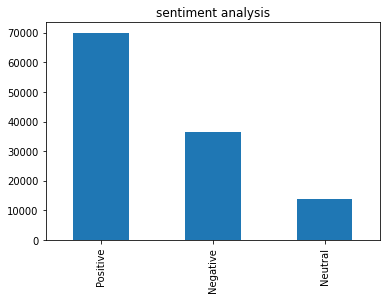

In [140]:
sid = SentimentIntensityAnalyzer()
data['senti_scores'] = data['clean_text'].apply(lambda Twit: sid.polarity_scores(Twit))
data['compound'] = data['senti_scores'].apply(lambda x: x['compound'])
data['sentiment_type']=''
data.loc[data.compound>0,['sentiment_type']]='Positive'
data.loc[data.compound==0,'sentiment_type']='Neutral'
data.loc[data.compound<0,'sentiment_type']='Negative'
data.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")
data.sample(3)

# **LDA MODELLING**

In [ ]:
# dictionary create
tokenize_texts=data['text_tokenize_ngram']
word_list=gensim.corpora.Dictionary(tokenize_texts)

# Filter list - eliminating words that can make noise
word_list.filter_extremes(no_below=1,no_above=0.7)

# vectorization of terms
documents_matrix=[word_list.doc2bow(terim) for terim in tokenize_texts]

In [ ]:
'''
#### 10 abstract topic - num topic created
'''
lda_model = gensim.models.ldamodel.LdaModel(corpus=documents_matrix,
                                            id2word=word_list,
                                            num_topics=10,
                                            passes=10)

In [ ]:
Topics=lda_model.print_topics(num_words=10)

df=pd.DataFrame(Topics)
df.rename(columns={0: "Enum", 1: "Details"},inplace=True)
df


In [144]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(lda_model,documents_matrix,word_list,mds="mmds")
'''
mmds:Metrik Çok Boyutlu Ölçekleme
tsne:t-dağıtılmış Stokastik Komşu Gömme
'''
pyLDAvis.display(vis)

# **PIVOT TABLES**

### TOP 20 USER ORDER BY FAVORITE COUNT

In [145]:
Name_Pivot = pd.pivot_table(data,
                                index=['user_id','screen_name'],
                                values=['text', 'favourites_count','hashtag_count','sentiment_type'],
                                aggfunc={'text': lambda x: x.count(), 'hashtag_count':'count',
                                        "favourites_count": np.sum,'sentiment_type':lambda x:(mode(x))[0][0],
                                        }).sort_values(ascending=False, by=['favourites_count']).reset_index()

top_20_names_fav_pivot=Name_Pivot[:20]
t_20_n_percentage=pd.DataFrame(top_20_names_fav_pivot.groupby('sentiment_type')['favourites_count'].agg(['sum','count']))
t_20_n_percentage['percentage']=(t_20_n_percentage['count']/t_20_n_percentage['count'].sum() * 100)

t_20_n_percentage.reset_index().to_excel('Top20_User_by_Favorite_Sent_Perc.xlsx',encoding="utf-8-sig",header=True,index=False)
# top_20_names_fav_pivot.to_excel('Top20_User_by_Favorite_Pivot.xlsx',encoding="utf-8-sig",header=True,index=False)

print(t_20_n_percentage)

                       sum  count  percentage
sentiment_type                               
Negative        16524650.0      6        30.0
Neutral          3796869.0      2        10.0
Positive        65574619.0     12        60.0


### TOP 20 HASHTAGS AND SENTIMENT RESULTS

In [146]:
'''
April 2020 hashtags interests:
1 - Covid19, World Health Day(7 April), Coronavirus - sentiment positive
2 - weight loss - negative inclined
3 - fitness motivation 
'''

tag_Pivot = pd.pivot_table(data[data['hashtags']!='bos'],
                                index=['hashtags'],
                                values=['hashtag_count','sentiment_type','compound'],
                                aggfunc={'hashtag_count':'count','sentiment_type':lambda x:(mode(x))[0][0],'compound':np.sum
                                        }).sort_values(ascending=False, by=['hashtag_count']).reset_index()
tag_df=tag_Pivot.value_counts()
tag_df=pd.DataFrame(tag_df).reset_index()
tag_df
hashlist=[]
hashlist2=[]
hashlist3=[]
for a in tag_df.index:
        for x in tag_df.loc[a,'hashtags'].lower().split():
                hashlist.append(x.strip())
                hashlist2.append(tag_df.loc[a,'hashtag_count'])
                hashlist3.append(tag_df.loc[a,'compound'])
hash_df=pd.DataFrame({'tag':hashlist,'hashcount':hashlist2,'compound':hashlist3})
del hashlist,hashlist2,hashlist3
tag_df=pd.DataFrame(hash_df.value_counts().reset_index())
tag_df=tag_df.rename(columns={0: "Count"})
tag_df
hash_df = pd.pivot_table(tag_df, index=['tag'],
                        values=['hashcount', "Count", "compound"],
                        aggfunc={"Count": np.sum, "compound": np.mean}).sort_values(ascending=False, by=["Count"]).reset_index()
del tag_df
hash_df['sentiment_type']=''
hash_df.loc[hash_df.compound>0,['sentiment_type']]='Positive'
hash_df.loc[hash_df.compound<0.15,'sentiment_type']='Neutral'
hash_df.loc[hash_df.compound<0,'sentiment_type']='Negative'
hash_df=hash_df[hash_df['Count']>=30]
hash_df=hash_df.sort_values(ascending=False,by=['Count']).reset_index(drop=True)
hash_df[:20]

import plotly.express as px
fig = px.bar(hash_df, x='sentiment_type', y='Count', text_auto='.2s',title="Hashtag Sentiment Analysis", width=1200)
fig.update_traces(textfont_size=12, textposition="outside", cliponaxis=False)
fig.show()
# hash_df.to_excel('HashtagsAnalysis.xlsx',encoding="utf-8-sig",header=True,index=False)

In [147]:
import emoji

def replace_x(x):
    x=x.replace('🤔','👀')
    x=x.replace('🤣','😂')
    x=x.replace('🙄','👀')
    x=x.replace('🥺','😒')
    x=x.replace('🥴','😟')
    x=x.replace('🙃','😃')
    x=x.replace('🙂','😃')
    x=x.replace('🥰','😊')
    x=x.replace('🤷','🙆')
    x=x.replace('🤢','😰')
    x=x.replace('🤪','😂')  
    return x

aaaaaa=data['text']
emojies=aaaaaa.apply(lambda x: emoji.distinct_emoji_list(replace_x(x)))
emojies=pd.DataFrame(emojies.value_counts()[:20])
emojies.dropna(inplace=True)

emojies.to_csv("emojies.csv", sep="\t",encoding="utf-8-sig",header=True)